In [1]:
import os, sys

module_path = os.path.abspath(os.path.join('../../'))

if module_path not in sys.path:
    sys.path.append(module_path)

from src.data_fcts import *
from src.retrain_fcts import *

from src.bench_fcts import *
from src.viz_fcts import plot_detector_param_noise, plot_detector_noise_scenario, plot_detector_param_noise_scenario_specific
from ast import literal_eval

/home/bastienzim/Documents/ShapleyDirs/Shap-Adwin/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
all_noises = [0, 0.001, 0.01, 0.05, 0.1, 0.5]

In [3]:

generate_nodrift_fcts = []
for noise_rate in all_noises:
    # NOISY 
    def generate_nodrift_df(noise_rate=noise_rate):

        D_G = Drift_generators(n_samples = n_samples, n_features = n_features)
        D_G.abrupt_concept_drift(drifts=[Drift(is_abrupt=True,
                                    start=n_samples-2,
                                    characteristic=[0.7-0.3*(0 % 2) for i in range(D_G.n_features)])])
        D_G.add_noise(noise_rate=noise_rate)
        D_G.drift_name = f"nodrift_noisy{str(noise_rate)[2:]}"
        
        return(D_G)
    generate_nodrift_fcts += [generate_nodrift_df]

In [4]:
n_samples = 3000
n_features = 4

In [5]:

generate_drift_fcts = []
for noise_rate in all_noises:
    # NOISY 
    def generate_noisy_smooth_concept_drift(n_samples = n_samples, noise_rate=noise_rate):
        D_G = Drift_generators(n_samples = n_samples, n_features = n_features)
        D_G.smooth_concept_drift(n_drift=1)
        D_G.add_noise(noise_rate=noise_rate)
        return(D_G)

    def generate_noisy_abrupt_concept_drift(n_samples = n_samples, noise_rate=noise_rate):
        D_G = Drift_generators(n_samples = n_samples, n_features = n_features)
        D_G.abrupt_concept_drift(n_drift=1)
        D_G.add_noise(noise_rate=noise_rate)
        return(D_G)

    def generate_noisy_gradual_concept_drift(n_samples = n_samples, noise_rate=noise_rate):
        D_G = Drift_generators(n_samples = n_samples, n_features = n_features)
        D_G.gradual_concept_drift(n_drift=1)
        D_G.add_noise(noise_rate=noise_rate)
        return(D_G)

    def generate_noisy_abrupt_covariate_drift(n_samples = n_samples, noise_rate=noise_rate):
        D_G = Drift_generators(n_samples = n_samples, n_features = n_features)
        d_centers = [(0, 0,
                    0.3, 0.25, 1),(0, 0.3, 0.5, 0, 0.25),(0, 0.5, 1, 0.25, 1)]
        D_G.abrupt_covariate_drift(d_centers=d_centers)
        D_G.add_noise(noise_rate=noise_rate)
        return(D_G)



            #generate_noisy_smooth_concept_drift
    noisy_fcts = [generate_noisy_smooth_concept_drift, generate_noisy_abrupt_concept_drift, generate_noisy_abrupt_covariate_drift,
                generate_noisy_gradual_concept_drift],
                 #generate_noisy_abrupt_covariate_drift]
                #generate_noisy_sine1, generate_noisy_sine2, generate_noisy_stagger]
    generate_drift_fcts += noisy_fcts


In [6]:

list_df_generate_fcts_special = []
for noise_rate in all_noises:
    # NOISY 
    def generate_noisy_stagger(noise_rate=noise_rate):
        D_G = Drift_generators()
        D_G.load_df("stagger_short")
        D_G.add_noise(noise_rate=noise_rate)
        return(D_G)
#
    def generate_noisy_sine1(noise_rate=noise_rate):
        D_G = Drift_generators()
        D_G.load_df("sine1_short")
        D_G.add_noise(noise_rate=noise_rate)
        return(D_G)
#
    def generate_noisy_sine2(noise_rate=noise_rate):
        D_G = Drift_generators()
        D_G.load_df("sine2_short")
        D_G.add_noise(noise_rate=noise_rate)
        return(D_G)

    noisy_fcts = [generate_noisy_stagger, generate_noisy_sine1, generate_noisy_sine2],
    list_df_generate_fcts_special += noisy_fcts


In [7]:
all_fcts_selected = [a+b for a,b in zip(list_df_generate_fcts_special, generate_drift_fcts)]
all_fcts_selected = [a+[b] for a,b in zip(all_fcts_selected, generate_nodrift_fcts)]

# Display all funcs

In [8]:
all_fcts_selected[0]

[<function __main__.generate_noisy_stagger(noise_rate=0)>,
 <function __main__.generate_noisy_sine1(noise_rate=0)>,
 <function __main__.generate_noisy_sine2(noise_rate=0)>,
 <function __main__.generate_noisy_smooth_concept_drift(n_samples=3000, noise_rate=0)>,
 <function __main__.generate_noisy_abrupt_concept_drift(n_samples=3000, noise_rate=0)>,
 <function __main__.generate_noisy_abrupt_covariate_drift(n_samples=3000, noise_rate=0)>,
 <function __main__.generate_noisy_gradual_concept_drift(n_samples=3000, noise_rate=0)>,
 <function __main__.generate_nodrift_df(noise_rate=0)>]

# RUN results

In [9]:
np.linspace(0.001, 0.00001, 6)

array([1.00e-03, 8.02e-04, 6.04e-04, 4.06e-04, 2.08e-04, 1.00e-05])

# Display Results
## KSWIN 

In [10]:
root_path = os.environ.get("RESULTS_ROOT_PATH")+"detectors_param/"
name = "retrain_KSWIN_alpha.csv"
df_perf_detector = pd.read_csv(root_path+name).drop(columns = ['Unnamed: 0'])

df_perf_detector.loc[:,"drift_type"] = df_perf_detector.drift_name.apply(lambda name: "".join([x for x in name if not x.isdigit()]).replace("_noisy",""))
df_perf_detector = df_perf_detector.reset_index()

In [11]:
param_name = "alpha"
detector_name = "KSWIN"

In [12]:
df_perf_detector.groupby(["noise_rate", param_name]).mean().head(3)

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


index  success  performance
noise_rate alpha                              
0.0        0.0001   59.5    0.625     1163.125
           0.0010   51.5    0.750      764.250
           0.0100   43.5    0.875      465.000

SAVED AT /home/bastienzim/Documents/ShapleyDirs/Shap-Adwin/figures/KSWIN_noise_alpha.pdf


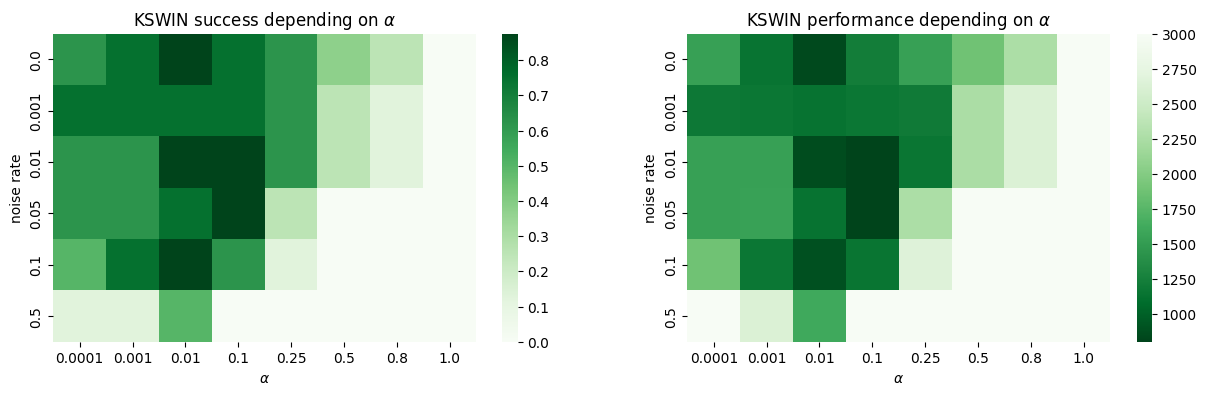

In [13]:
ax = plot_detector_param_noise(df_perf_detector, param_name, detector_name, n_samples)

### Highlight scenarios which underperform

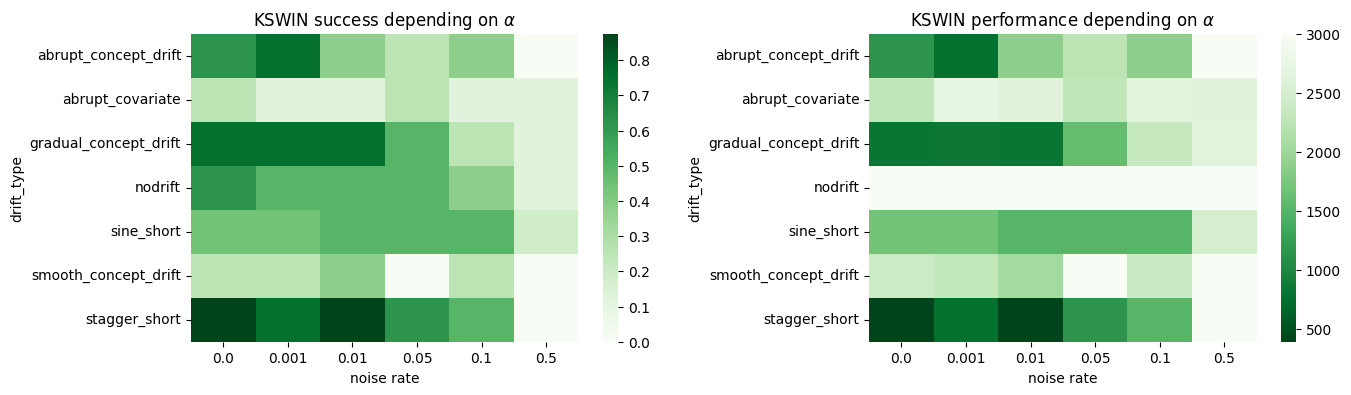

In [14]:
ax = plot_detector_noise_scenario(df_perf_detector, param_name, detector_name, n_samples)

__Please select some param values__

In [15]:
selected_alphas = [0.01]

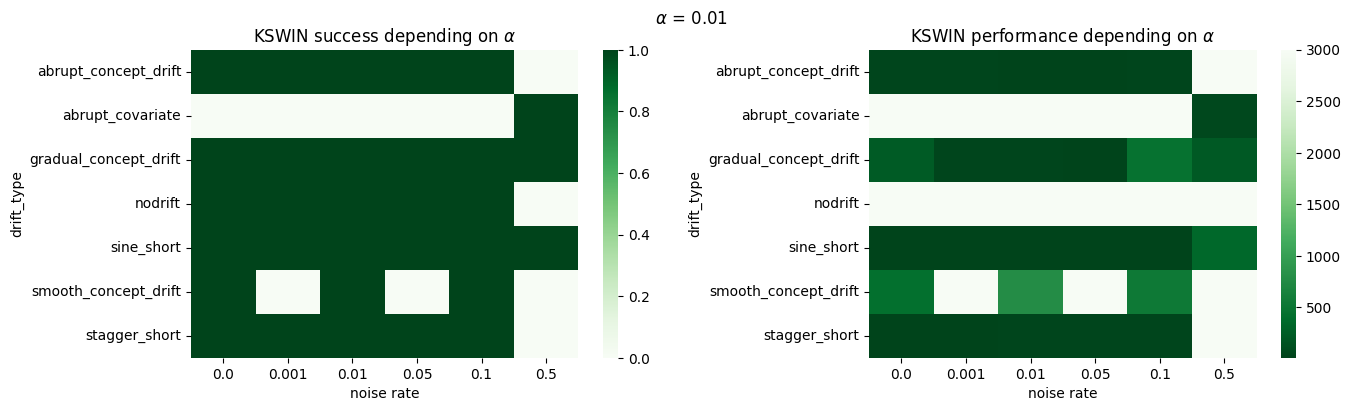

In [16]:
ax = plot_detector_param_noise_scenario_specific(df_perf_detector, param_name, detector_name, n_samples, selected_param_values=selected_alphas)

## Shap KSWIN 

In [17]:
root_path = os.environ.get("RESULTS_ROOT_PATH")+"detectors_param/"
name = "retrain_KSWIN_shap_alpha.csv"
df_perf_detector = pd.read_csv(root_path+name).drop(columns = ['Unnamed: 0'])

df_perf_detector.loc[:,"drift_type"] = df_perf_detector.drift_name.apply(lambda name: "".join([x for x in name if not x.isdigit()]).replace("_noisy",""))
df_perf_detector = df_perf_detector.reset_index()

In [18]:
df_perf_detector = df_perf_detector[df_perf_detector.noise_rate<0.5]

In [19]:
param_name = "alpha"
detector_name = "SHAP KSWIN"

In [20]:
df_perf_detector.groupby(["noise_rate", "alpha"]).mean().head(3)

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


index   success  performance
noise_rate alpha                               
0.0        0.0001   52.0  0.857143   534.000000
           0.0010   45.0  0.428571  2385.571429
           0.0100   38.0  0.000000  3428.571429

SAVED AT /home/bastienzim/Documents/ShapleyDirs/Shap-Adwin/figures/SHAP_KSWIN_noise_alpha.pdf


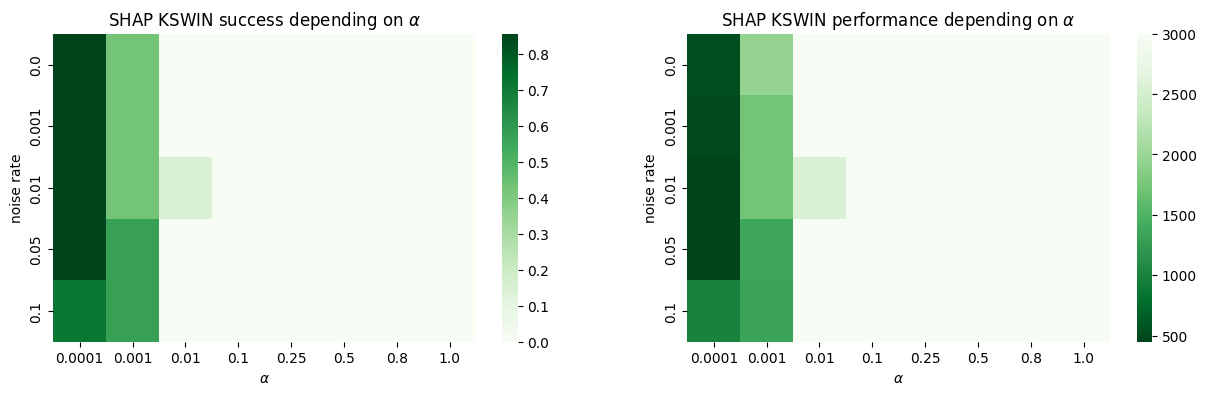

In [21]:
ax = plot_detector_param_noise(df_perf_detector, param_name, detector_name, n_samples)

### Highlight scenarios which underperform

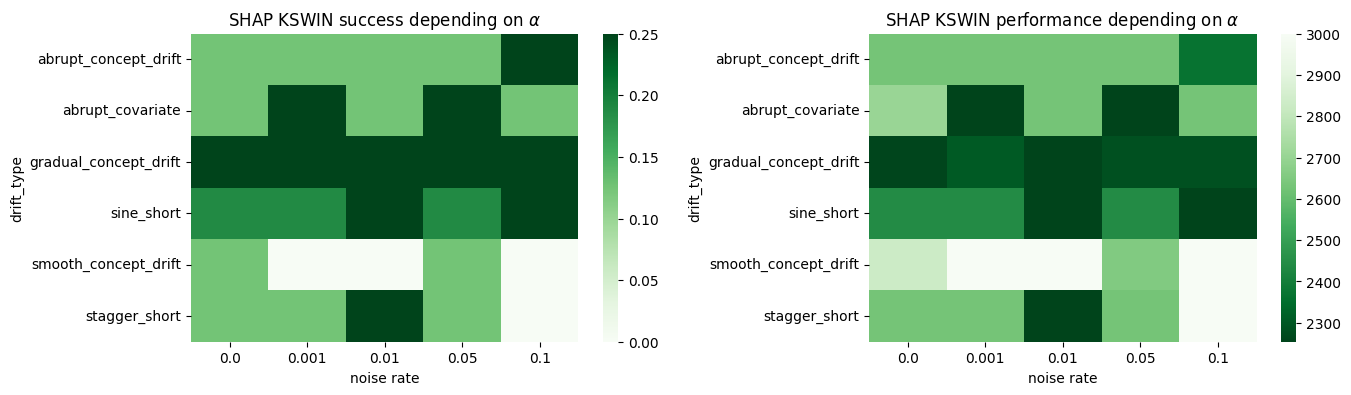

In [22]:
ax = plot_detector_noise_scenario(df_perf_detector, param_name, detector_name, n_samples)

__Please select some param values__

In [23]:
selected_alphas = [0.0001]

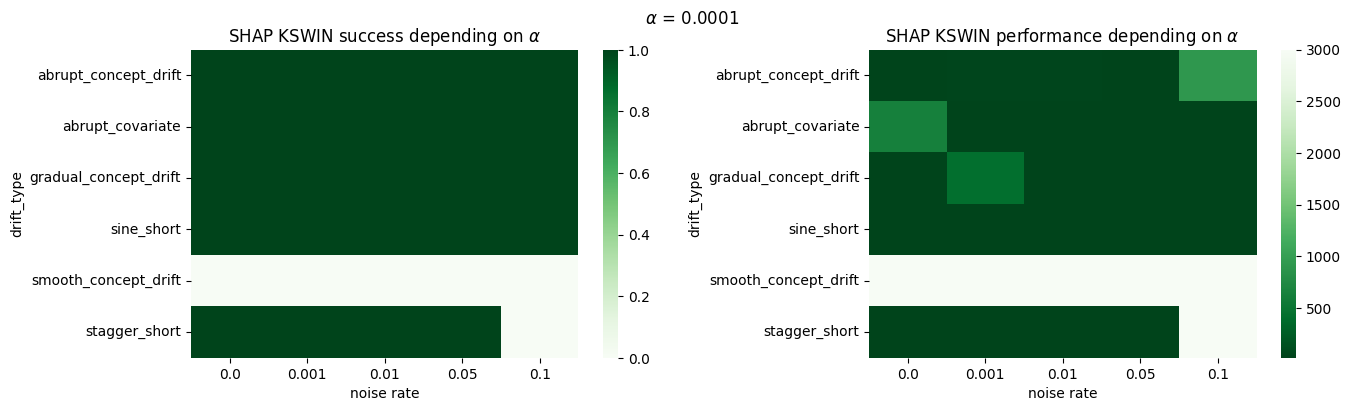

In [24]:
ax = plot_detector_param_noise_scenario_specific(df_perf_detector, param_name, detector_name, n_samples, selected_param_values=selected_alphas)